In [1]:
import numpy as np
import math
from numpy.random import randn
import matplotlib.pyplot as plt
from tensorflow import keras

In [3]:
dungeon_generator = keras.models.load_model("Dungeon_Models/generator_model_epoch_200.h5")
room_generator = keras.models.load_model("Room_Models/generator_model_epoch_200.h5")

In [4]:
def generate_random_noise(random_dim, n_samples):
  noise = randn(random_dim * n_samples)
  noise = noise.reshape(n_samples, random_dim)
  return noise

def generate_samples(generator, random_dim, n_samples):
  noise = generate_random_noise(random_dim, n_samples)
  X_fake = generator.predict(noise)
  return X_fake

def plot_10_samples(samples, figsize):
  plt.figure(figsize=(20,8))
  for i in range(len(samples)):
    plt.subplot(2, 5, i+1)
    plt.imshow(samples[i].reshape(figsize), interpolation='nearest')
    plt.axis('off')
  plt.tight_layout()

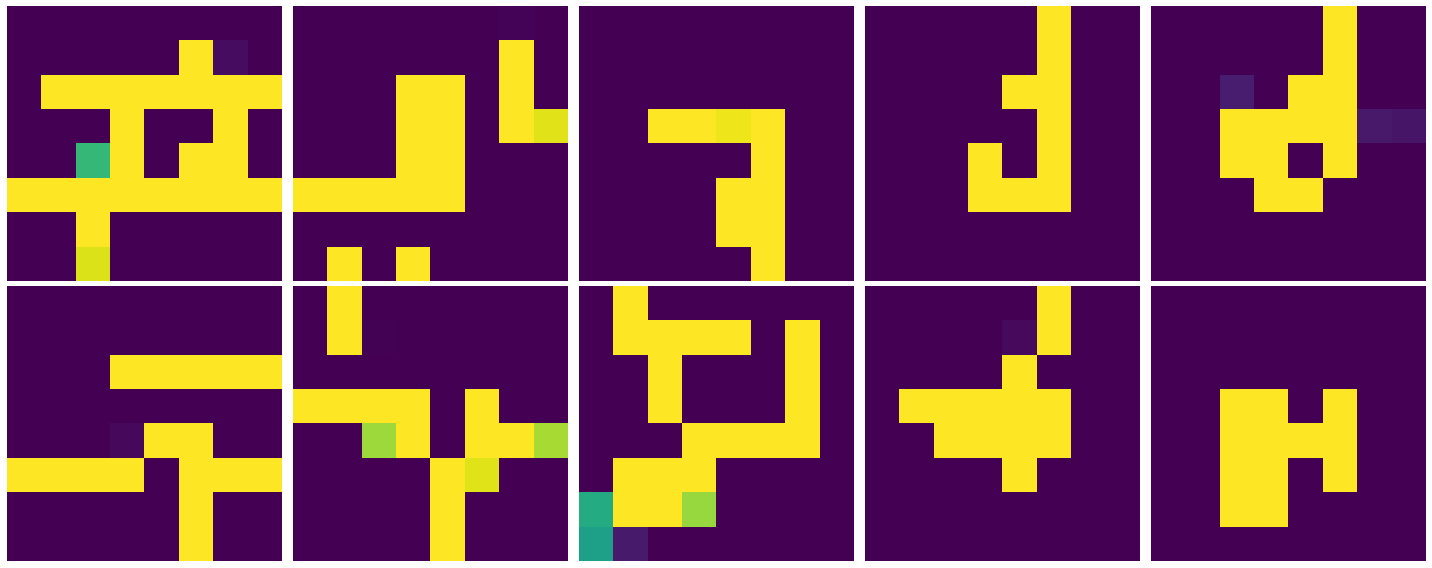

In [5]:
dungeon_samples = generate_samples(dungeon_generator, 20, 10)

plot_10_samples(dungeon_samples, (8,8))

In [6]:
def create_island(sample, i, j, island):
  island.append([i,j])
  sample[i][j] = 0
  if i > 0 and sample[i-1][j] == 1:
    create_island(sample, i-1, j, island)
  if i < sample.shape[0] - 1 and sample[i+1][j] == 1:
    create_island(sample, i+1, j, island)
  if j > 0 and sample[i][j-1] == 1:
    create_island(sample, i, j-1, island)
  if j < sample.shape[1] - 1 and sample[i][j+1] == 1:
    create_island(sample, i, j+1, island)
    
def get_islands(sample):
  tmp_sample = np.copy(sample)
  islands = []
  for i in range(tmp_sample.shape[0]):
    for j in range(tmp_sample.shape[1]):
      if tmp_sample[i][j] == 1:
        island = []
        create_island(tmp_sample, i, j, island)
        islands.append(island)
  return islands
       
def find_nearest_rooms(island1, island2):
  distances = np.zeros((len(island1),len(island2)))
  for i in range(len(island1)):
    for j in range(len(island2)):
      distances[i][j] = math.sqrt((island1[i][0] - island2[j][0])**2 + (island1[i][1] - island2[j][1])**2)
  index_min = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
  return island1[index_min[0]], island2[index_min[1]]

def connect_islands(sample):
  islands = get_islands(sample)
  if len(islands) == 1:
    return
  
  nearest_rooms = find_nearest_rooms(islands[0], islands[1])
  if nearest_rooms[0][0] < nearest_rooms[1][0]:
    sample[nearest_rooms[0][0] + 1][nearest_rooms[0][1]] = 1
    connect_islands(sample)

  elif nearest_rooms[0][0] > nearest_rooms[1][0]:
    sample[nearest_rooms[1][0] + 1][nearest_rooms[1][1]] = 1
    connect_islands(sample)

  elif nearest_rooms[0][1] < nearest_rooms[1][1]:
    sample[nearest_rooms[0][0]][nearest_rooms[0][1] + 1] = 1
    connect_islands(sample)

  elif nearest_rooms[0][1] > nearest_rooms[1][1]:
    sample[nearest_rooms[1][0]][nearest_rooms[1][1] + 1] = 1
    connect_islands(sample)

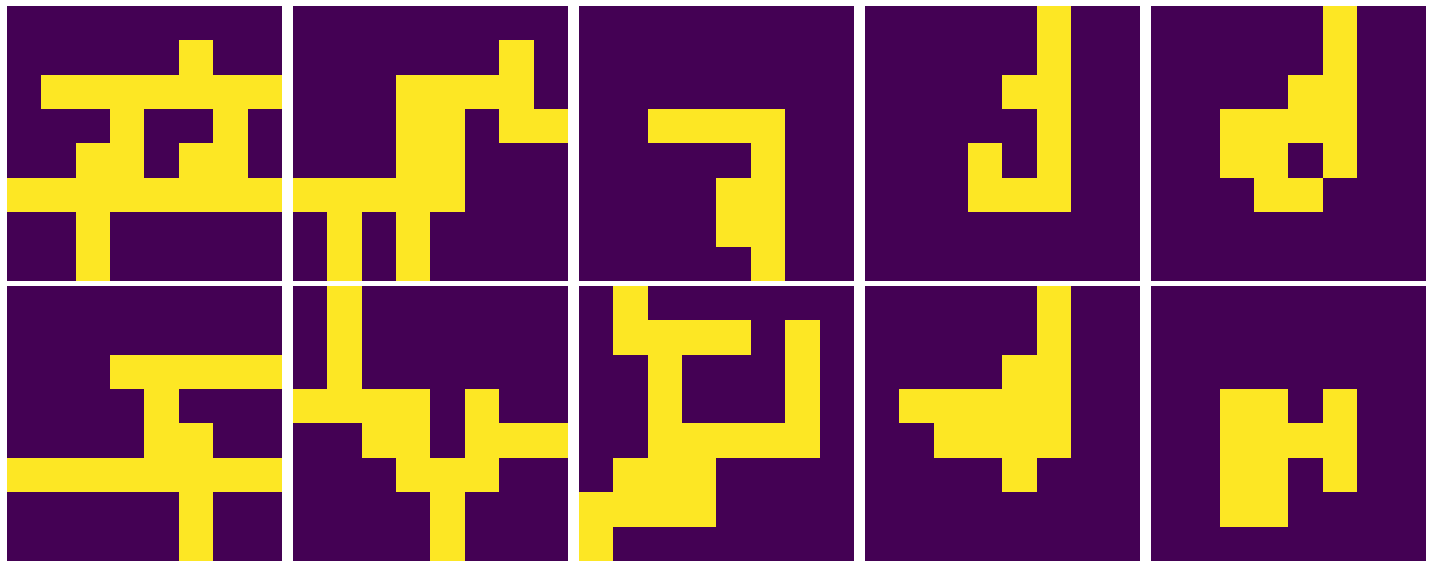

In [7]:
def correct_dungeon(samples):
  corrected_samples = (samples * 0.5) + 0.5
  corrected_samples = np.round(corrected_samples)
  for sample in corrected_samples:
    connect_islands(sample)
  return corrected_samples
    
corrected_dungeon_samples = correct_dungeon(dungeon_samples)
plot_10_samples(corrected_dungeon_samples, (8,8))

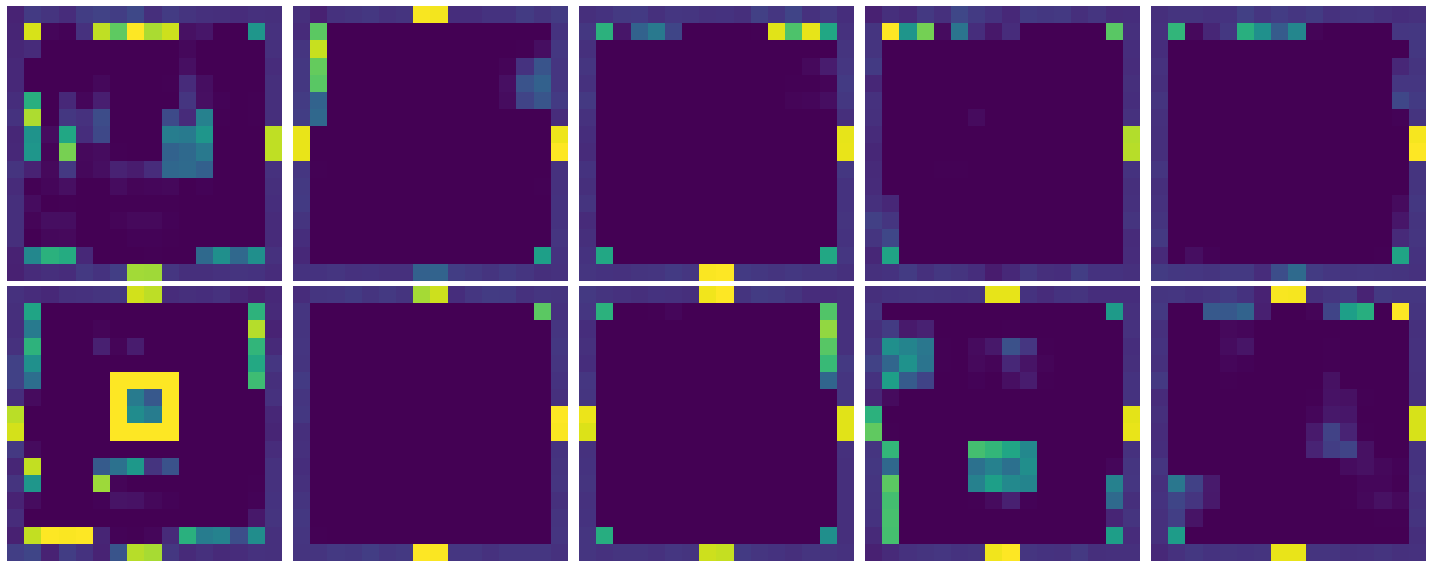

In [8]:
room_samples = generate_samples(room_generator, 25, 10)

plot_10_samples(room_samples, (16,16))

In [9]:
def correct_walls(sample):
  sample[0,:] = 1
  sample[:,0] = 1
  sample[15,:] = 1
  sample[:,15] = 1
    
  for i in range(1, sample.shape[0] - 1):
    for j in range(1, sample.shape[1] - 1):
      if sample[i,j] == 1:
        sample[i,j] = 0

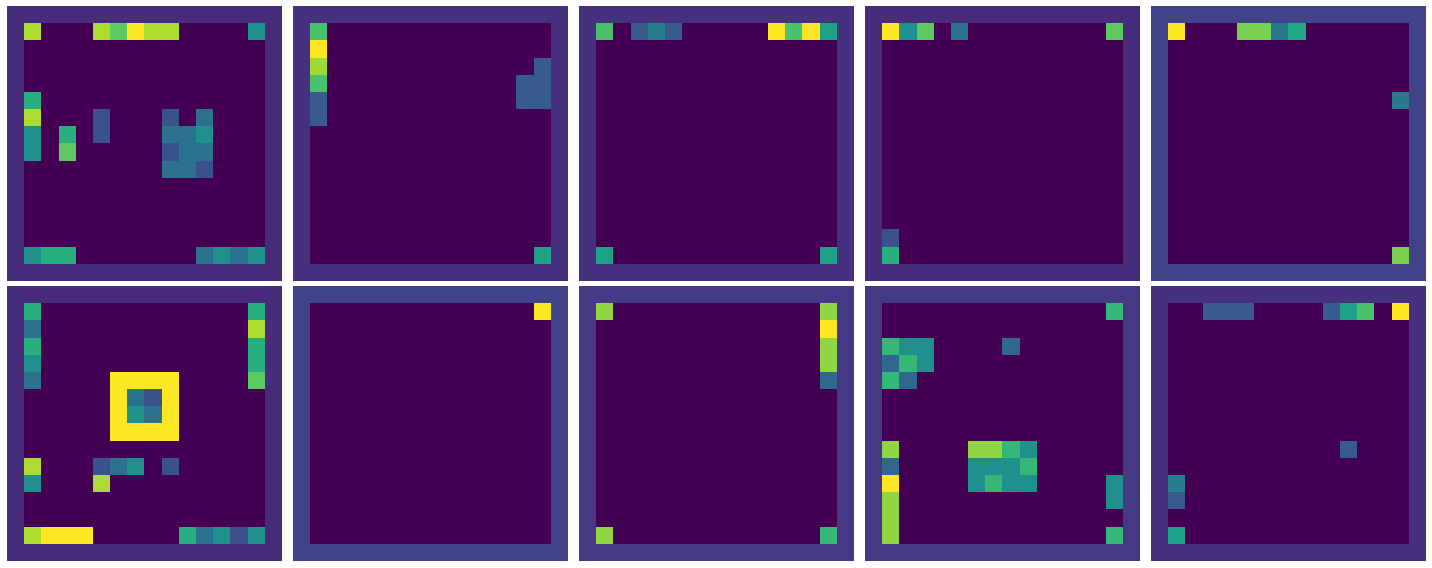

In [10]:
def correct_room(samples):
  corrected_samples = (samples * 4) + 4
  corrected_samples = np.round(corrected_samples)
  for sample in corrected_samples:
    correct_walls(sample)
  return corrected_samples

corrected_room_samples = correct_room(room_samples)
plot_10_samples(corrected_room_samples, (16,16))

In [44]:
def generate_level():
  dungeon_generator = keras.models.load_model("Dungeon_Models/generator_model_epoch_200.h5")
  room_generator = keras.models.load_model("Room_Models/generator_model_epoch_200.h5")
    
  dungeon = generate_samples(dungeon_generator, 20, 1)
  dungeon = correct_dungeon(dungeon).reshape(8,8)
    
  level = np.empty([128, 128]).astype(int)

  for i in range(dungeon.shape[0]):
    for j in range(dungeon.shape[1]):
      if dungeon[i, j] == 0:
        level[i * 16 : (i+1) * 16, j * 16 : (j+1) * 16] = 0
      else:
        room = generate_samples(room_generator, 25, 1)
        room = correct_room(room).reshape(16, 16)
        
        if i > 0 and dungeon[i-1, j] == 1:
          room[0, 7:9] = 7
        if i < 7 and dungeon[i+1, j] == 1:
          room[15, 7:9] = 7
        if j > 0 and dungeon[i, j-1] == 1:
          room[7:9, 0] = 7
        if j < 7 and dungeon[i, j+1] == 1:
          room[7:9, 15] = 7

        level[i * 16 : (i+1) * 16, j * 16 : (j+1) * 16] = room
    
  return level

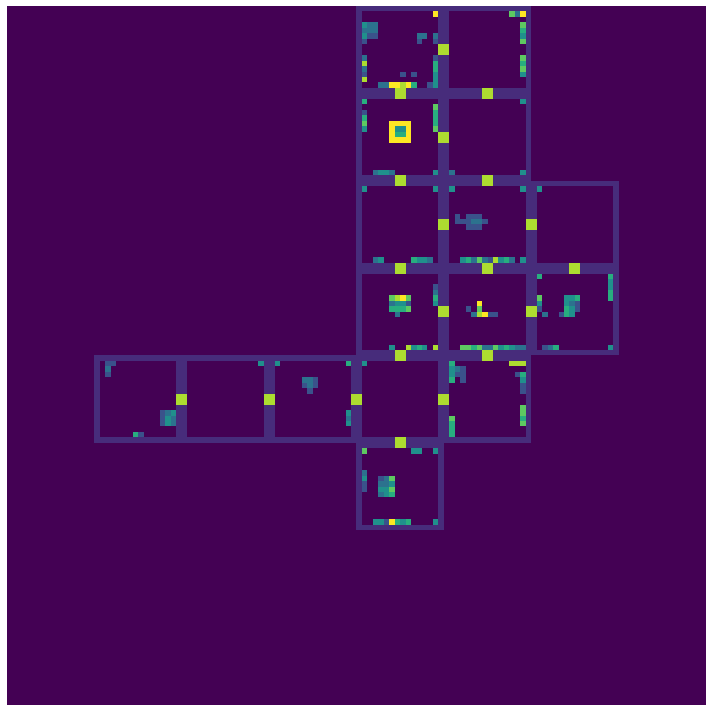

In [46]:
level = generate_level()
plt.figure(figsize=(10,10))
plt.imshow(level)
plt.axis('off')
plt.tight_layout()